# Optimization Methods, Lab №3


## Acknowledgments

- Tovmasian Arman M3232
- Kister Artemii M3232
- Khimchenko Maxim M3232

## Imports

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_regression
from memory_profiler import memory_usage

## Common SGD function

In [24]:
def sgd_optimizer(X, y, lr=0.01, epochs=100, batch_size=32, optimizer='sgd', lr_schedule=None, **kwargs):
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)
    history = []

    if optimizer == 'momentum':
        momentum = kwargs.get('momentum', 0.9)
        v = np.zeros(n_features)
    elif optimizer == 'nesterov':
        momentum = kwargs.get('momentum', 0.9)
        v = np.zeros(n_features)
    elif optimizer == 'adagrad':
        epsilon = kwargs.get('epsilon', 1e-8)
        G = np.zeros(n_features)
    elif optimizer == 'rmsprop':
        beta = kwargs.get('beta', 0.9)
        epsilon = kwargs.get('epsilon', 1e-8)
        E_g2 = np.zeros(n_features)
    elif optimizer == 'adam':
        beta1 = kwargs.get('beta1', 0.9)
        beta2 = kwargs.get('beta2', 0.999)
        epsilon = kwargs.get('epsilon', 1e-8)
        m = np.zeros(n_features)
        v = np.zeros(n_features)

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            gradients = -2 / len(X_batch) * X_batch.T.dot(y_batch - X_batch.dot(theta))
            
            if optimizer == 'sgd':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                theta -= lr * gradients
            
            elif optimizer == 'momentum':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                v = momentum * v - lr * gradients
                theta += v

            elif optimizer == 'nesterov':
                if lr_schedule:
                    lr = lr_schedule(epoch * n_samples // batch_size + i // batch_size)
                theta_lookahead = theta + momentum * v
                gradients = -2 / len(X_batch) * X_batch.T.dot(y_batch - X_batch.dot(theta_lookahead))
                v = momentum * v - lr * gradients
                theta += v

            elif optimizer == 'adagrad':
                G += gradients**2
                adjusted_lr = lr / (np.sqrt(G) + kwargs.get('epsilon', 1e-8))
                theta -= adjusted_lr * gradients

            elif optimizer == 'rmsprop':
                E_g2 = beta * E_g2 + (1 - beta) * gradients**2
                adjusted_lr = lr / (np.sqrt(E_g2) + kwargs.get('epsilon', 1e-8))
                theta -= adjusted_lr * gradients

            elif optimizer == 'adam':
                t = epoch * n_samples // batch_size + i // batch_size + 1
                m = beta1 * m + (1 - beta1) * gradients
                v = beta2 * v + (1 - beta2) * gradients**2
                m_hat = m / (1 - beta1**t)
                v_hat = v / (1 - beta2**t)
                theta -= lr * m_hat / (np.sqrt(v_hat) + kwargs.get('epsilon', 1e-8))

        loss = np.mean((y - X.dot(theta))**2)
        history.append(loss)

    return theta, history

## Data generation

In [23]:
def generate_dots_simple(n, a, b, noise=1.0):
    X = np.linspace(-10, 10, n)
    y = a * X + b + np.random.normal(scale=noise, size=n)
    return np.vstack((X, y)).T


def exact_ans(dots):
    """Функция для линейной регрессии (для расчета истинного решения)"""
    X = dots[:, 0]
    y = dots[:, 1]
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

## Parameters

In [7]:
lr = 0.01
epochs = 100
batch_size = 32

### Default GD

In [8]:
theta_sgd, history_sgd = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='sgd')

## SGD Modifications

### Momentum

In [10]:
theta_momentum, history_momentum = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='momentum', momentum=0.9)

### Nesterov

In [11]:
theta_nesterov, history_nesterov = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='nesterov', momentum=0.9)

### Adagrad

In [12]:
theta_adagrad, history_adagrad = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='adagrad', epsilon=1e-8)

### RMSProp

In [13]:
theta_rmsprop, history_rmsprop = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='rmsprop', beta=0.9, epsilon=1e-8)

### Adam

In [14]:
theta_adam, history_adam = sgd_optimizer(X, y, lr=lr, epochs=epochs, batch_size=batch_size, optimizer='adam', beta1=0.9, beta2=0.999, epsilon=1e-8)

## Profile Section

In [26]:
def profile_task(dots, batch, modification, lr=0.01, epochs=100):
    start_time = time.time()
    mem_usage = memory_usage((sgd_optimizer, (dots[:, 0].reshape(-1, 1), dots[:, 1]), 
                             {'lr': lr, 'epochs': epochs, 'batch_size': batch, 'optimizer': modification}),
                             max_usage=True)
    elapsed_time = time.time() - start_time
    
    theta, _ = sgd_optimizer(dots[:, 0].reshape(-1, 1), dots[:, 1], lr=lr, epochs=epochs, batch_size=batch, optimizer=modification)
    a, b = theta[0], 0  # Assuming single feature for simplicity
    delta = np.mean((dots[:, 1] - (a * dots[:, 0] + b))**2)
    
    return elapsed_time, delta, mem_usage


def profile_all_tasks(n: int, test_cnt: int = 10, lr=0.01, epochs=100):
    results = []

    for mod in Modifications:
        print(mod)
        for batch in range(1, n + 1):
            print(mod, batch)
            total_time = 0
            total_delta = 0
            total_memory = 0
            
            for _ in range(test_cnt):
                dots = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), 1)
                elapsed_time, delta, mem_usage = profile_task(dots, batch, mod, lr=lr, epochs=epochs)
                total_time += elapsed_time
                total_delta += delta
                total_memory += mem_usage
            
            results.append([mod, batch, total_delta / test_cnt, total_time / test_cnt, total_memory / test_cnt])
    
    df = pd.DataFrame(results, columns=['Method', 'Batch Size', 'Delta', 'Time (s)', 'Memory (MB)'])
    return df

In [41]:
n = 50
test_cnt = 5
df = profile_all_tasks(n, test_cnt)
df

,Method,Batch Size,Delta,Time (s),Memory (MB)
0,sgd,1,72.672407,0.675112,61.539062
1,sgd,2,34.693911,0.916459,61.113281
2,sgd,3,39.117081,0.921884,60.967188
3,sgd,4,67.493271,0.957934,61.014844
4,sgd,5,46.078580,0.992818,60.965625
...,...,...,...,...,...
295,adam,46,1406.570761,0.895742,29.315625
296,adam,47,938.072944,0.899559,29.317969
297,adam,48,519.581113,0.897897,29.296094
298,adam,49,918.260952,0.898735,29.353125


## Memory Plot

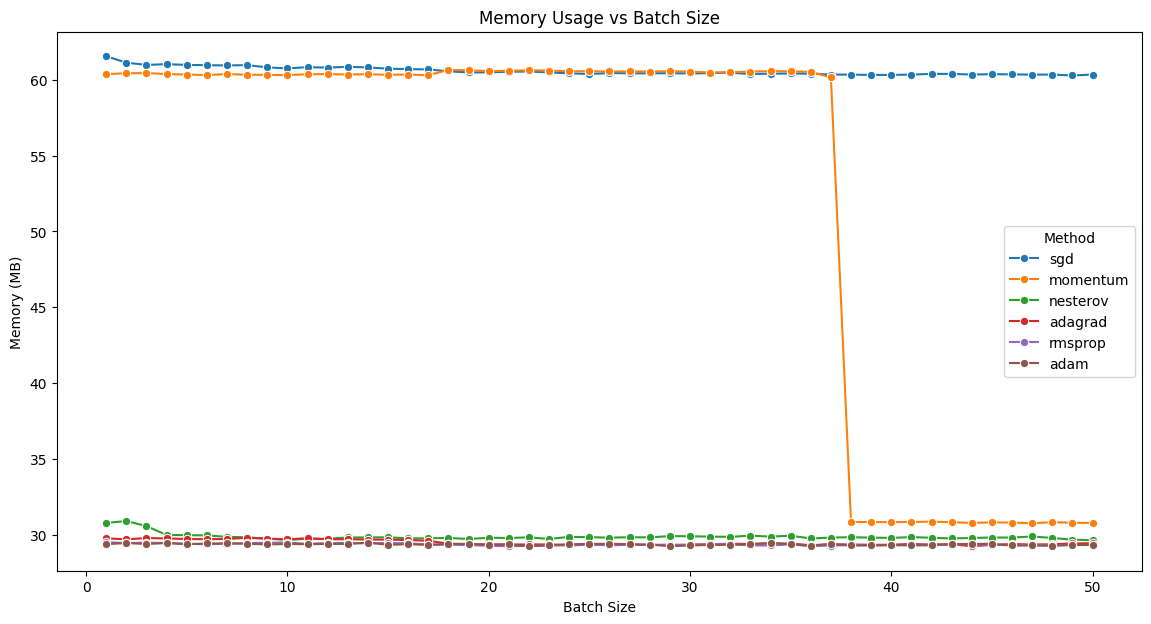

In [42]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Memory (MB)', hue='Method', marker='o')
plt.title('Memory Usage vs Batch Size')
plt.show()

## Delta Plot

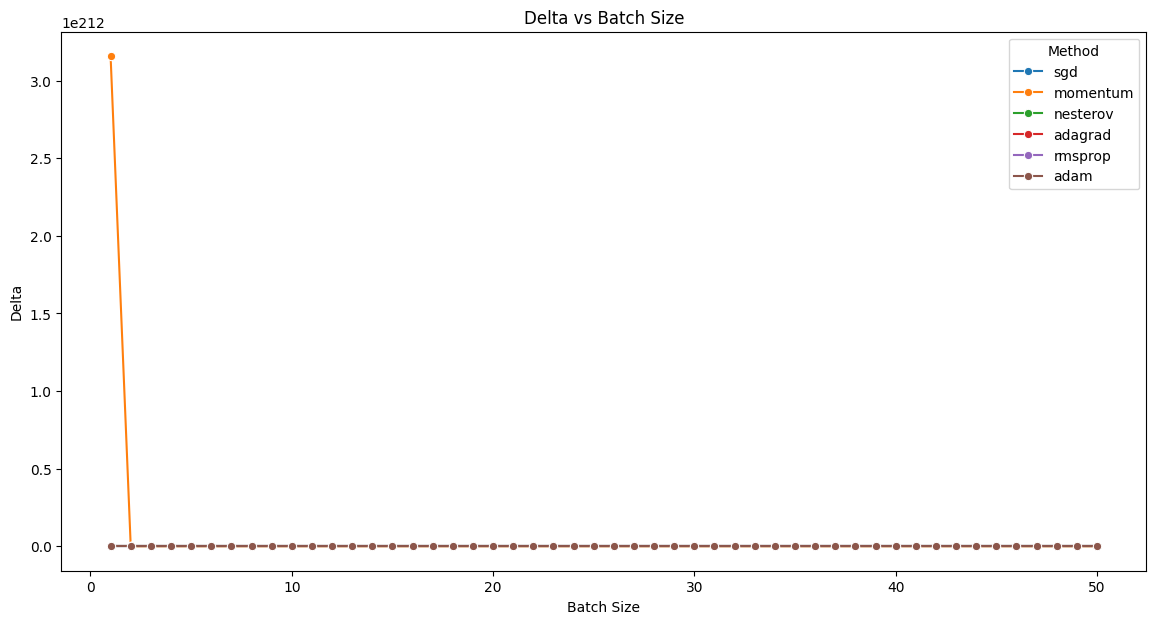

In [43]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Delta', hue='Method', marker='o')
plt.title('Delta vs Batch Size')
plt.show()

## Time Plot

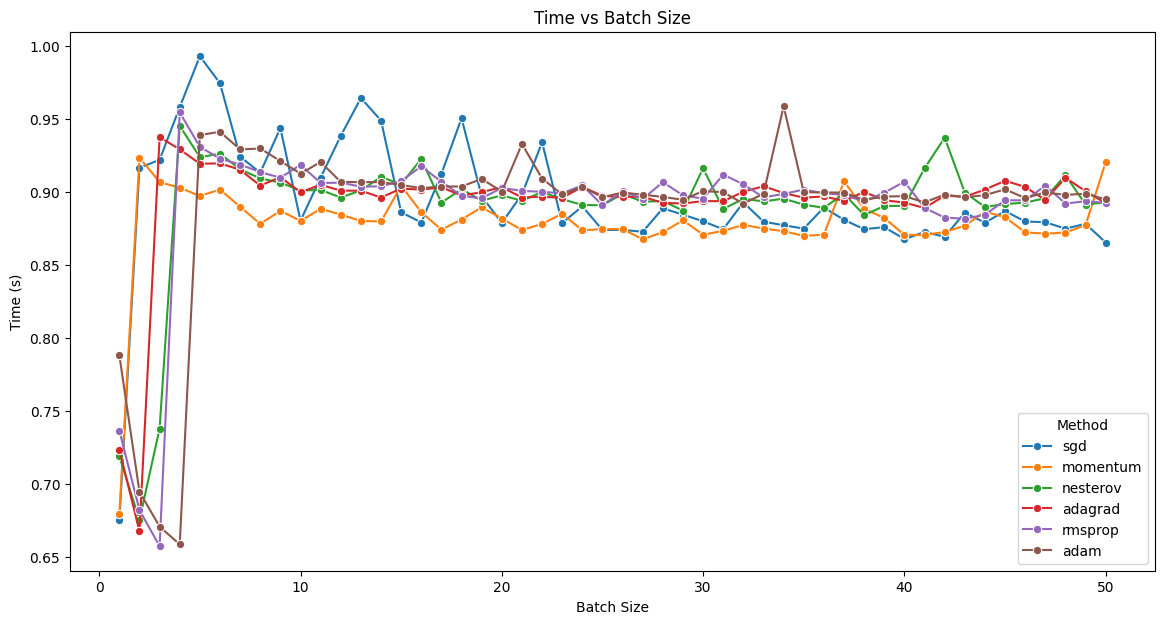

In [44]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Batch Size', y='Time (s)', hue='Method', marker='o')
plt.title('Time vs Batch Size')
plt.show()